In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#classifiers
from sklearn.linear_model import Perceptron
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

pd.set_option('display.max_columns', 100) # to display all columns at all time
pd.options.mode.chained_assignment = None # to ignore false-positive warnings about chained assignments

In [2]:
data = pd.read_csv('ElectionsData.csv',header=0)
train = pd.read_csv('modified/afterpp_train.csv', header=0)
test = pd.read_csv('modified/afterpp_test.csv', header=0)
validation = pd.read_csv('modified/afterpp_validation.csv',header=0)

# merged train and test
train_test = pd.concat([train, test], keys=['train', 'test'])

for df in [train,test,validation,train_test]:
    df.drop([x for x in df.columns.values if 'Unnamed' in x],axis=1,inplace=True)

In [3]:
def pick_best_classifier2(classifiers, names, df,fn,number_of_iterations=1):
    data = df.drop(['Vote'],axis=1)
    data_labels = df['Vote']
 
    best_score = df.shape[0]*2
    best_clf = None
    best_clf_name = None

    for i in range(number_of_iterations):
        if number_of_iterations > 1:
            print "iteration:",i+1
            
        X_train, X_test, Y_train, Y_test = train_test_split(data,data_labels)

        for name, clf in zip(names, classifiers):
            print "current classifier:", name
            clf.fit(X_train, Y_train)
            prediction = clf.predict(X_test)
            score = fn(clf.classes_,Y_test, prediction)
            print name, "L1 score:", score
            if score < best_score:
                best_clf = clf
                best_score = score
                best_clf_name = name
        print ""
    print "Best classifier:", best_clf_name, "with score:", best_score
    return best_clf
    
    
#try them all!!! our classifiers, with our parameters are in there
#but since this is automatic, let's just try them all and let the best one win!
classifiers = [
    KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree'),
    SVC(kernel="linear", C=1000000),
    #SVC(gamma=5, C=1000000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators = 60,criterion='gini',n_jobs=-1),
    MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5,2)),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    Perceptron()]

names = ["Nearest Neighbors",
         "Linear SVM",
         "RBF SVM",
         "Decision Tree",
         "Random Forest",
         "Neural Net",
         "AdaBoost",
         "Naive Bayes",
         "QDA",
         "LDA",
         "Perceptron"]

def L1(classes,actual,predicted):
    c = Counter()
    for i in range(len(predicted)):
        c[predicted[i]] += 1
    values_actual = actual.value_counts()
    return sum(abs(values_actual[cls]-c[cls]) for cls in classes)

clf2 = pick_best_classifier2(classifiers, names, train, L1, 1)

current classifier: Nearest Neighbors
Nearest Neighbors L1 score: 194
current classifier: Linear SVM
Linear SVM L1 score: 484
current classifier: RBF SVM
RBF SVM L1 score: 348
current classifier: Decision Tree
Decision Tree L1 score: 56
current classifier: Random Forest


/Users/ronsailer/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Random Forest L1 score: 1670
current classifier: Neural Net
Neural Net L1 score: 1912
current classifier: AdaBoost
AdaBoost L1 score: 562
current classifier: Naive Bayes
Naive Bayes L1 score: 2482
current classifier: QDA
QDA L1 score: 1644
current classifier: LDA
LDA L1 score: 1070

Best classifier: Decision Tree with score: 56


/Users/ronsailer/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/ronsailer/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/ronsailer/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/ronsailer/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/ronsailer/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


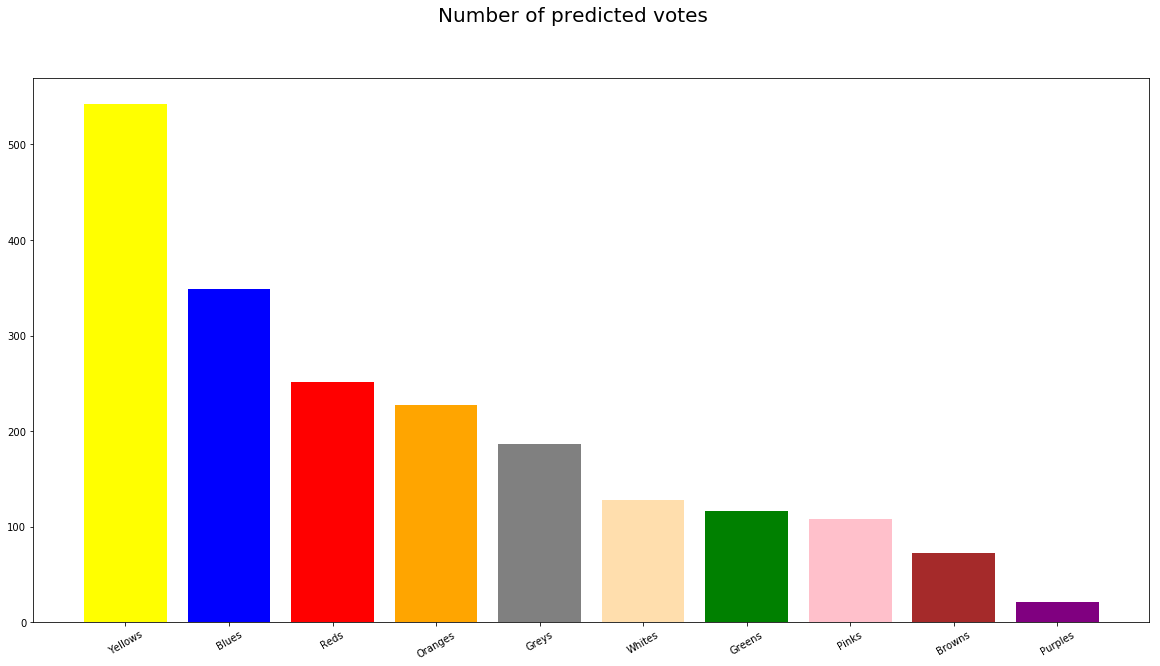

In [6]:
#Fit to the training set and predict on the test set
train_data = train.drop(['Vote'],axis=1)
train_data_labels = train['Vote']

test_data = test.drop(['Vote'],axis=1)
test_labels = test['Vote']

predictions = clf2.predict(test_data)

c = Counter()
for i in range(len(predictions)):
    c[predictions[i]] += 1
    
c = c.most_common()
parties, votes = zip(*[x for x in c])

colors = [x[:-1] if x != 'Whites' else 'navajowhite' for x in parties]

f, ax = plt.subplots(figsize=(20, 10))
f.suptitle('Number of predicted votes',fontsize=20)
ax.bar(range(len(c)), [x[1] for x in c], align="center",color=colors)
plt.xticks(range(len(c)), parties, rotation=30)

plt.show()